We want to solve the BVP $$ \begin{cases} -u_{xx} + \sigma u = f, \\ u(a)=u_1,\;u(b)=u_2\end{cases} $$

We suppose to be given
- $p$ which is the polynomial degree of basis functions
- $N$ which is the number of uniform elements in [a,b]
- $\sigma,a,b,u_1,u_2$ which are the parameters of the problem

The numerical integrations for the load vector are done by Gaussian quadrature, with 5 points. 

We then want to compute the error in $L^2$ norm, and create convergence plots. Recall
$$ E = \sqrt{\int_a^b \|u(x)-u_h(x)\|^2dx}, $$
and even this quantity will be computed by Gaussian quadrature

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as sl

We introduce the number of elements and the degrees of the polynomial basis functions on which we want to test the FEM code.

In [7]:
Nrange = 2**np.arange(2,8) #Number of elements on which we test it
Prange= np.array([1,2]) #Degree of the polynomial basis functions

We define the basis functions for linear and quadratic elements. This function evaluates them at a specific point $x\in [a,b]$.

In [8]:
def Basis_Functions(p,x):
    if p==1:
        return np.array([1-x, x])
    elif p==2:
        return np.array([(x-1)*(2*x-1), 4*(1-x)*x, x*(2*x-1)])

We store the nodes $X$ and weights $W$ of Gaussian quadrature formula with $5$ nodes. These nodes and weights are rescaled/translated so that they refer to the interval $[0,1]$ instead of the usual $[-1,1]$ where they are deifned,  i.e. so that $$ \int_0^1 f(x)dx \approx \sum_{i=1}^5 w_i f(x_i). $$

In [9]:
def Gauss_Data():
    X = (np.array([-0.9061798459386641,-0.5384693101056831,0,0.5384693101056831,
    0.9061798459386641])+1)/2
    W = 0.5*np.array([0.23692688505618908,0.4786286704993664,128/225,
    0.4786286704993664,0.23692688505618908])
    return X,W

We now define the stiffness and mass matrices for the reference element $[0,1]$. Recall that they are defined as
$$ M_{ij} = \int_0^1\hat{\varphi}_i(\xi)\hat{\varphi}_j(\xi)d\xi  $$
$$ K_{ij} = \int_0^1\hat{\varphi}'_i(\xi)\hat{\varphi}'_j(\xi)d\xi,\quad i,j\in\{1,..,p+1\}  $$

In [10]:
def Element_Matrix(p,type):
    if type == "Mass":
        if p == 1:
            return (1/6)*np.matrix([[2,1],[1,2]],dtype="float")
        elif p == 2:
            return (1/30)*np.matrix([[4,2,-1],[2,16,2],[-1,2,4]],dtype="float")
    elif type == "Stiffness":
        if p == 1:
            return np.matrix([[1,-1],[-1,1]],dtype="float")
        elif p == 2:
            return (1/3)*np.matrix([[7,-8,1],[-8,16,-8],[1,-8,7]],dtype="float")

We now define the load vector for the reference element $[0,1]$, due to the contributions of a specific element $e_i\in \mathcal{T}_h$. Recall that if we refer to the element $e_i$ with left vertex $c_i$, we get  $$f_{e_i}^{(r)} = h \int_0^1 \hat{\varphi}_r(\xi)f(c_i+h\xi)d\xi \approx h\sum_{j=1}^5 w_j \hat{\varphi}_r(x_j)f(c_i+x_j h) = \\ h\sum_{j=1}^5 w_j\varphi_{e_{ir}}(c_i+x_j h)f(c_i+x_j h),\;\;r\in{0,..,p}$$
where $\varphi_{e_{ir}}$ is the restriction to $e_i$ of the basis function which is associated to $\hat{\varphi}_r$ via $x(\xi) = c_i + \xi h$.

In [11]:
def Element_Vector(p,h,c,X,W,func):
    f_e = np.zeros(p+1)
    for i in range(0,len(X)):
        f_e += W[i]*func(h*X[i]+c)*Basis_Functions(p,h*X[i]+c)
    f_e = h*f_e
    return f_e

We can now combine the contributions of the elements to the matrices and the load vector to obtain the global versions of these quantities. To do so, we sum the local contributions to the correct position in the global setting.

In [12]:
def Assemble_Linear_System(p,N,sig,a,b,func):
    #func is the right hand side of the PDE
    #sig is the sigma parameter in the PDE
    # Initializing assembly parameters.
    T = np.linspace(a,b,N+1)    # Uniform grid on the domain.
    h = (b-a)/N                 # Uniform element length.
    dim = N*p+1                 # Degrees of freedom.
    A = np.zeros((dim,dim))     # Linear matrix.
    f = np.zeros(dim)           # Load vector.
    X,W = Gauss_Data()          # Gaussian quadrature data.

    # Starting the assembly.
    for i in range(0,N):
        A_e = (1/h)*Element_Matrix(p,"Stiffness")
        if sig != 0:
            A_e += h*sig*Element_Matrix(p,"Mass")
        A[p*i:p*(i+1)+1,p*i:p*(i+1)+1] += A_e
        f_e = Element_Vector(p,h,T[i],X,W,func)
        f[p*i:p*(i+1)+1] += f_e

    return A,f

The Galerkin formulation now reduces to a linear system $Au=f$. To solve it, we hence use a sparse solver.

In [17]:
def Solve_Linear_System(A,f,p,N,u1,u2):
    # Condensating the equation system.
    A = A[1:N*p,1:N*p] #since we just have Dirichlet BCs we can solve
                       #the system just for internal nodes
    A = sp.csr_matrix(A)
    f = f[1:N*p]

    # Solving the system.
    u0 = sl.spsolve(A,f)

    # Enforcing Dirichlet conditions.
    u = np.zeros(N*p+1)
    u[1:N*p] = u0
    u[0] = u1
    u[N*p] = u2
    return u

We now compute the $L^2$ error done with this FEM approximation. Since we need to compute an integral, we do so with the same Gaussian quadrature formula as before. Indeed,
$$ E = \sqrt{\int_a^b \|u(x)-u_h(x)\|^2dx} = \sqrt{\sum_{i=0}^{n-1}\int_{c_i}^{c_{i+1}}\|u(x)-u_h(x)\|^2dx} $$
$$ \approx \sqrt{h\sum_{i=0}^{n-1}\sum_{j=1}^5w_j\|u(c_i+x_j h)-u_h(c_i+x_j h)\|^2} $$
where we recall
$$ u_h(x) = \sum_{k=0}^n u_k\varphi_k(x) $$ and $Au=f$.
Thus,
$$ E \approx \sqrt{h\sum_{i=0}^{n-1}\sum_{j=1}^5w_j\|u(c_i+x_j h)-\sum_{k=i}^{i+p} u_k\varphi_k(c_i+x_j h)\|^2}. $$
Recall that we can just consider $k\in\{i,...,i+p\}$ because of the support of the basis functions which makes them the only basis functions different from zero on the element $e_i$.

In [18]:
def Compute_Global_Error(u,p,N,a,b,exactSol):
    ERR = 0
    h = (b-a)/N
    X,W = Gauss_Data()
    T = np.linspace(a,b,N+1)
    for i in range(0,N):
        e = 0 #this stores the i-th term of the outer summation
        c = T[i] #left vertex of the i-th element e_i
        co = u[p*i:p*(i+1)+1] #we just work with the terms related to non
                            #zero basis funcitons on e_i
        for j in range(0,len(X)):
            b = Basis_Functions(p,h*X[j]+c)
            u_ex = exactSol(h*X[j]+c)
            e += W[j]*(np.dot(co,b)-u_ex)**2
        e = h*e
        ERR += e
    ERR = np.sqrt(ERR)

    return ERR

In [19]:
def solveProblem(sig,a,b,u1,u2,func,exactSol,string):
    ERR = np.zeros([2,len(Nrange)])
    i = 0
    for p in Prange:
        j = 0
        for N in Nrange:
            # Assembly of the linear system.
            A,f = Assemble_Linear_System(p,N,sig,a,b,func)

            # Solving the linear system.
            u = Solve_Linear_System(A,f,p,N,u1,u2)

            # Calculating the global error.
            ERR[i,j] = Compute_Global_Error(u,p,N,a,b,exactSol)
            j+=1
        i+=1
    fig = plt.figure(figsize=(10,10),dpi=100)
    plt.loglog(Nrange, ERR[0,:],'r-',label="p=1")
    plt.loglog(Nrange, ERR[1,:],'k-',label="p=2")
    plt.legend()
    plt.xlabel("Number of elements")
    plt.ylabel("L2 error")
    plt.title(string)
    plt.show()

Definition of the data we need to solve the PDE

In [20]:
Exact1 = lambda x: np.sin(np.pi * x)
Force1 = lambda x: np.pi**2 * np.sin(np.pi * x)

Exact2 = lambda x: np.exp(-x**2)
Force2 = lambda x: 4*(1-x**2)*np.exp(-x**2)

Output of the results we want

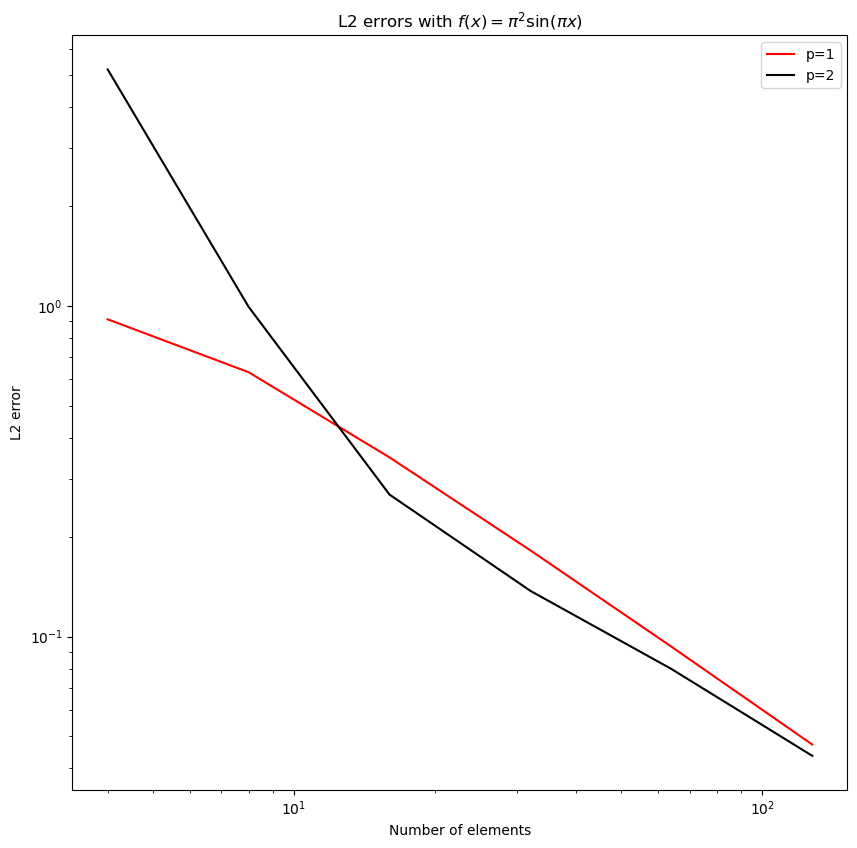

In [21]:
sig = 0 #\sigma in the PDE
a = 0 #left bound of the domain
b = 2 #right bound of the domain
u1 = 0 #left Dirichlet BC
u2 = 0 #right Dirichlet BC
title1 = "L2 errors with $f(x)=\pi^2\sin{(\pi x)}$"
solveProblem(sig,a,b,u1,u2,Force1,Exact1,title1)

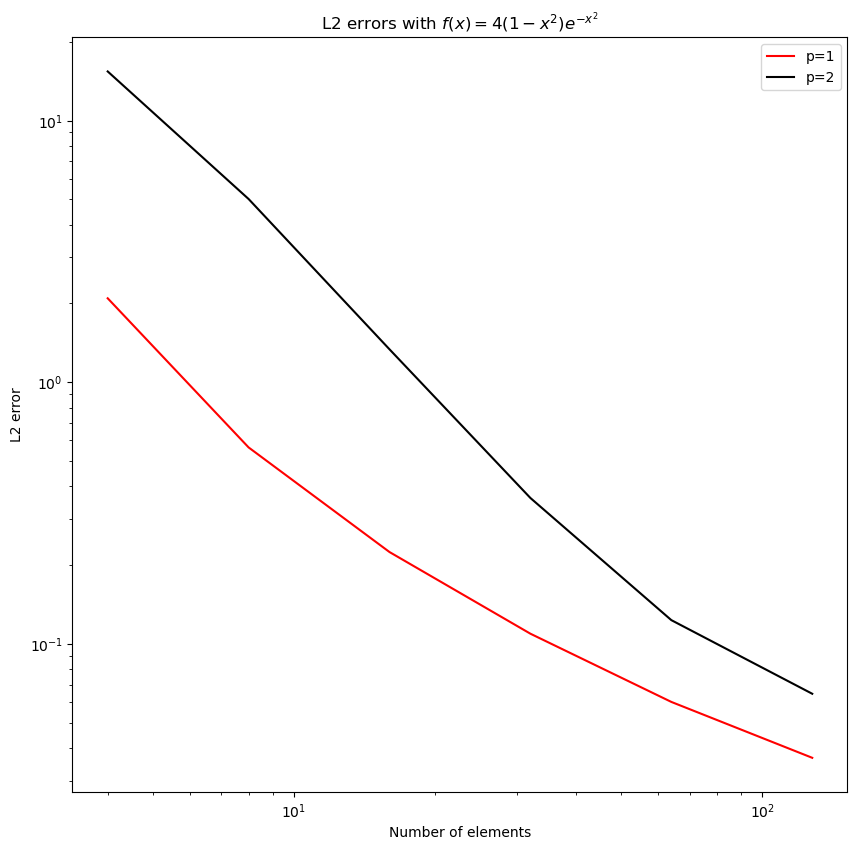

In [22]:
sig = 2 #\sigma in the PDE
a = -2 #left bound of the domain
b = 2 #right bound of the domain
u1 = np.exp(-4) #left Dirichlet BC
u2 = np.exp(-4) #right Dirichlet BC
title2 = "L2 errors with $f(x)=4(1-x^2)e^{-x^2}$"
solveProblem(sig,a,b,u1,u2,Force2,Exact2,title2)